In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import re
import pandas as pd
from transformers import AutoTokenizer
from datasets import Dataset, load_from_disk

### Load Model and Tokenizer

In [3]:

MODEL_CKPT = 'paust/pko-t5-larget'
MODEL_CKPT = 'paust/pko-t5-base'
MODEL_CKPT = 'EleutherAI/polyglot-ko-3.8b'
MODEL_CKPT = 'EleutherAI/polyglot-ko-5.8b'
MODEL_CKPT = 'EleutherAI/polyglot-ko-1.3b'
MODEL_CKPT = 'paust/pko-t5-base'

tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

print(MODEL_CKPT)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


paust/pko-t5-base


### Load Data

In [4]:
DATA_PATH = 'data/model_dev_raw/model_dev_raw_v4.pickle'

In [5]:
df_data = pd.read_pickle(DATA_PATH)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100146 entries, 0 to 100885
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             100146 non-null  int64         
 1   create_date    100146 non-null  datetime64[ns]
 2   title          100146 non-null  object        
 3   title_content  100146 non-null  object        
 4   len_tokenized  100146 non-null  int64         
 5   label          100146 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 5.3+ MB


In [6]:
# for idx, row in df_data.iterrows():
#     if idx == 1000:
#         break
#     print(f'Row {idx}')
#     print('input')
#     print(row.title_content)
#     print()
#     print('output')
#     print(row.label)
#     print()
#     print()

### 전처리 계획

- 라벨 앞뒤로 붙은 punctuation 제거
- 라벨 내 key-phrases 중에서 띄어쓰기 기준으로 길이 4 이상인 항목 제거 (보류)

### Preprocess

In [7]:
def regulate_sequence(string):
    pattern = re.compile(r'- .+\n') # - 댄스가수 유랑단 > 댄스가스 유랑단; 
    found = pattern.findall(string)
    if len(found) > 5:
        removed = [re.sub(r'^- ', '', keyphrase) for keyphrase in found]
        string = '; '.join(removed)

    pattern = re.compile(r'\d+\. .+\n') # 1. 댄스가수 유랑단 > 댄스가스 유랑단; 
    found = pattern.findall(string)
    if len(found) > 5:
        removed = [re.sub(r'^\d+\. ', '', keyphrase) for keyphrase in found]
        string = '; '.join(removed)
    
    return string

In [8]:
def remove_noises(string):
    string = re.sub(r'key-phrases:', '', string, flags=re.IGNORECASE)
    string = string.replace('\n', ' ').strip()
    
    if string[0] in ';.':
        string = string[1:]
    if string[-1] in ';.':
        string = string[:-1]
    return string.strip()

test_case = '; 농협은행; ESG경영; 상생경영; 제1회 대한민국 리딩금융 ESG 어워드; 친환경경영; 지배구조; 녹색금융; '
test_case = ';농협은행; ESG경영; 상생경영; 제1회 대한민국 리딩금융 ESG 어워드; 친환경경영; 지배구조; 녹색금융. '

remove_noises(test_case)

'농협은행; ESG경영; 상생경영; 제1회 대한민국 리딩금융 ESG 어워드; 친환경경영; 지배구조; 녹색금융'

In [9]:
def remove_quotes(string):
    quotes = '"' + "'"
    key_phrases = [key_phrase.strip() for key_phrase in string.split(';') if key_phrase != '']

    temp = []
    for key_phrase in key_phrases:
        if len(key_phrase) > 0 and key_phrase[0] in quotes and key_phrase[-1] in quotes:
            key_phrase = key_phrase[1:-1]
        temp.append(key_phrase)
    
    return '; '.join(temp)

test_case = "'농협은행'; 'ESG경영'; '상생경영'; '제1회 대한민국 리딩금융 ESG 어워드'; '친환경경영'; '지배구조'; '녹색금융'"

remove_quotes(test_case)

'농협은행; ESG경영; 상생경영; 제1회 대한민국 리딩금융 ESG 어워드; 친환경경영; 지배구조; 녹색금융'

In [10]:
def preprocess_str(string):
    string = regulate_sequence(string)
    string = remove_noises(string)
    string = remove_quotes(string)
    return string

In [11]:
def preprocess(df):
    df.rename(columns={'title_content': 'input_text', 'label': 'target_text'}, inplace=True)
    df['target_text'] = df['target_text'].apply(preprocess_str)
    return df

In [12]:
preprocessed_data = preprocess(df_data)

### Check Preprocessed

In [13]:
checker = preprocessed_data.target_text.str.contains('\n')
checker = preprocessed_data.target_text.str.contains(r'^- ', regex=True)
checker = preprocessed_data.target_text.str.contains(r'^\d+\. ', regex=True)
checker = preprocessed_data.target_text.str.contains('key-phrases:')
checked = preprocessed_data[checker]

for idx, row in checked.iterrows():
    print(f'Row {idx}')
    print('target_text')
    print(row.target_text)
    print()

### Add len_tokenized_target_text Col. and Investigate

In [14]:
preprocessed_data['len_tokenized_target_text'] = preprocessed_data.target_text.apply(lambda x: len(tokenizer(x)['input_ids']))

(<Axes: >,
 count    100146.000000
 mean         55.936613
 std          21.578053
 min           2.000000
 25%          44.000000
 50%          51.000000
 75%          62.000000
 max         826.000000
 Name: len_tokenized_target_text, dtype: float64)

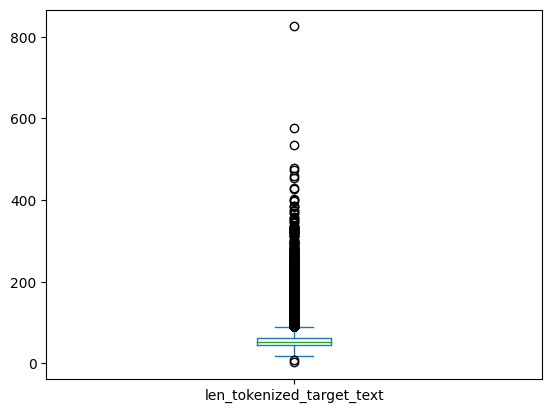

In [15]:
preprocessed_data.len_tokenized_target_text.plot(kind='box'), preprocessed_data.len_tokenized_target_text.describe()

### seq len =< 64 labels only

In [16]:
checker = preprocessed_data.len_tokenized_target_text <= 64
preprocessed_data[checker].len_tokenized_target_text.describe()
preprocessed_data = preprocessed_data[checker]
preprocessed_data.len_tokenized_target_text.describe()

count    79472.000000
mean        48.362316
std          8.084109
min          2.000000
25%         42.000000
50%         48.000000
75%         55.000000
max         64.000000
Name: len_tokenized_target_text, dtype: float64

In [17]:
# cursor = 0
# for idx, row in preprocessed_data.iterrows():
#     keyphrases = row.target_text.split('; ')
#     for keyphrase in keyphrases:
#         if keyphrase not in row.input_text:
#             print(row.input_text)
#             print(keyphrase)
#             print()
#             cursor += 1
#             if cursor == 100:
#                 break
#     if cursor == 100:
#         break

In [18]:
# for idx, row in preprocessed_data.iterrows():
#     print(f'Row {idx}')
#     print('target_text')
#     print(row.target_text)
#     print()

### Save Preprocessed Data

In [19]:
# preprocessed_data.to_pickle('data/model_dev/model_dev_v4.pickle')

### Encoding / Train Eval Split

In [20]:
### seq2seq
prefix = "generate keyphrases: "
max_input_length = 1024
max_target_length = 64

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["input_text"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding=False)

    labels = tokenizer(examples["target_text"], max_length=max_target_length, truncation=True, padding=False)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [20]:
MODEL_CKPT = 'EleutherAI/polyglot-ko-1.3b'

tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

In [22]:
### clm
max_length = 2048
src_prefix = "[generate keyphrases]"
trg_prefix = "[keyphrases generated]"

def preprocess_function(examples):
    inputs = [src_prefix + src + trg_prefix + trg + tokenizer.eos_token for src, trg in zip(examples["input_text"], examples["target_text"])]
    model_inputs = tokenizer(inputs, max_length=max_length, truncation=True, padding=False)
    return model_inputs

new_tokens = ['[generate keyphrases]', '[keyphrases generated]']
tokenizer.add_tokens(new_tokens)
tokenizer.save_pretrained('clm_tokenizer')

('clm_tokenizer/tokenizer_config.json',
 'clm_tokenizer/special_tokens_map.json',
 'clm_tokenizer/tokenizer.json')

In [23]:
dataset = Dataset.from_pandas(preprocessed_data).shuffle(seed=100).train_test_split(3000, seed=100)
train_dataset = dataset['train']
eval_dataset = dataset['test']

In [24]:
train_dataset = train_dataset.map(
    preprocess_function, 
    batched=True, 
    num_proc=4, 
    remove_columns=train_dataset.column_names
)

eval_dataset = eval_dataset.map(
    preprocess_function, 
    batched=True, 
    num_proc=4,
)

print(train_dataset)
print(eval_dataset)

Map (num_proc=4):   0%|          | 0/76472 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/3000 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 76472
})
Dataset({
    features: ['id', 'create_date', 'title', 'input_text', 'len_tokenized', 'target_text', 'len_tokenized_target_text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3000
})


In [34]:
train_dataset.save_to_disk('data/model_dev/model_dev_v4_polyglot_1.3b_train.hf')
eval_dataset.save_to_disk('data/model_dev/model_dev_v4_polyglot_1.3b_eval.hf')

Saving the dataset (0/1 shards):   0%|          | 0/76472 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3000 [00:00<?, ? examples/s]

In [35]:
train_dataset = load_from_disk('data/model_dev/model_dev_v4_polyglot_1.3b_train.hf')
eval_dataset = load_from_disk('data/model_dev/model_dev_v4_polyglot_1.3b_eval.hf')

In [36]:
print(train_dataset)
print(eval_dataset)

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 76472
})
Dataset({
    features: ['id', 'create_date', 'title', 'input_text', 'len_tokenized', 'target_text', 'len_tokenized_target_text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3000
})


In [37]:
import random

rand_idx = random.randint(0, len(eval_dataset)-1)

sample = eval_dataset['input_ids'][rand_idx]

tokenizer.decode(sample)

'[generate keyphrases]美 온라인 달군 \'트럼프 체포\' 사진…생성AI가 만들었네 생성AI가 만든 가짜뉴스/사진= 미국 온라인 커뮤니티\'성추문 입막음\' 논란으로 수사를 받았던 도널드 트럼프 전 미국 대통령이 경찰에 체포되는 \'가짜\' 이미지가 확산하고 있다. 해당 이미지는 생성 AI(인공지능)를 활용해 만든 이미지로 나타났다.22일(현지시간) AP통신 등은 트럼프 전 대통령이 뉴욕 경찰에 체포되는 사진이 각종 SNS(사회관계망)을 중심으로 확산하고 있다고 보도했다. 문제가 된 사진 속에는 트럼프가 체포되며 강하게 저항하는 모습이나 경찰을 피해 도망치는 모습 등이 담겼다.그러나 해당 이미지는 생성 AI를 활용해 만들어진 가짜 이미지로 나타났다. AP통신은 "트럼프 대통령은 체포되지 않았다"고 전했으며 뉴욕 경찰 역시 "트럼프 전 대통령은 구금된 바 없다"고 밝혔다.가짜 이미지를 만든 사람은 영국의 온라인 매체 벨링켓의 창립자이자 저널리스트인 엘리엇 히긴으로 드러났다. 히긴은 "이미지 생성 AI 서비스 미드저니(Midjourney)를 통해 제작한 일종의 패러디였다"며 "조작된 이미지가 얼마나 실제 같은지 알 수 있다"고 말했다.생성AI가 만든 가짜뉴스/사진= 미국 온라인 커뮤니티실제로 해당 이미지에는 현실성이 떨어지는 점이 발견된다. 트럼프 전 대통령이 경찰 벨트를 차고 있거나, 그의 다리가 세 개로 보이기도 한다.이와 관련 풍자를 목적으로 만들어냈다 하더라도 생성AI를 활용한 이미지가 가짜뉴스에 무분별하게 활용될 수 있다는 지적이 나온다. 딥페이크 사진 전문가 헨리 아이더는 뉴스위크와의 인터뷰에서 "AI 전문가들은 가짜라는 것을 눈치챌 수 있겠지만, 기술을 잘 모르는 사람들은 다르게 받아들일 수 있다"고 전했다.한편, 트럼프 전 대통령은 2016년 대선 직전 한 포르노 배우와 과거 성관계한 사실을 숨기기 위해 회삿돈으로 합의금을 지급하고 장부를 조작했다는 의혹을 받는다. 뉴욕 검찰은 관련 수사를 마무리하고 기소할지 여부를 검토하고 있는 상